In [49]:
!pip install fuzzywuzzy

In [50]:
import pandas as pd
import numpy as np

import requests
from requests.auth import HTTPBasicAuth
import string
import warnings
import json

warnings.filterwarnings("ignore")


# for fuzzy matching
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [51]:
def get_url_list():

    # the cocktaildb url can be scraped alphabetically, i.e., there is a URL for each starting character of a cocktail name - a,b,c.. 1,2,.. etc

    url_list = []
    main_url = 'https://www.thecocktaildb.com/api/json/v1/1/search.php?f='

    for i in string.printable:
        url_list.append(main_url+i)

    return url_list

In [52]:
def scrape_cocktail_list():

    cocktail_list = []
    url_list = get_url_list()

    for i in url_list:
        try:
            r = requests.get(i, verify=False)
            cocktail_list.append(r.json())
        except:
            pass
    return cocktail_list

In [53]:
cocktail_list = scrape_cocktail_list()

In [54]:
def get_ingredients(cocktail_dict):

    ingredient = cocktail_dict['strIngredient1']
    i = 2

    ingredient_list = ""

    while ingredient:

        ingredient_list = ingredient + ", " + ingredient_list
        ingredient = cocktail_dict['strIngredient'+str(i)]

        i = i+1

    return ingredient_list

In [55]:
cocktails_info = []

for i in range(len(cocktail_list)):
    try:
      for j in range(len(cocktail_list[i]['drinks'])):
            cocktail = {}
            cocktail['drink'] = cocktail_list[i]['drinks'][j]['strDrink']
            cocktail['ingredients'] = get_ingredients(cocktail_list[i]['drinks'][j])
            cocktail['instructions'] = cocktail_list[i]['drinks'][j]['strInstructions']

            cocktails_info.append(cocktail)
    except:
        pass

In [56]:
cocktails_info[:2]

[{'drink': '155 Belmont',
  'ingredients': 'Orange juice, Vodka, Light rum, Dark rum, ',
  'instructions': 'Blend with ice. Serve in a wine glass. Garnish with carrot.'},
 {'drink': '1-900-FUK-MEUP',
  'ingredients': 'Pineapple juice, Cranberry juice, Amaretto, Malibu rum, Midori melon liqueur, Chambord raspberry liqueur, Grand Marnier, Absolut Kurant, ',
  'instructions': 'Shake ingredients in a mixing tin filled with ice cubes. Strain into a rocks glass.'}]

In [57]:
cocktail_df = pd.DataFrame(cocktails_info)

In [58]:
cocktail_df.describe()

,drink,ingredients,instructions
count,916,916,916
unique,441,437,406
top,GG,"Wild Turkey, 151 proof rum,","Shake all ingredients with ice, strain into a ..."
freq,4,7,24


In [59]:
cocktail_df['drink'] = cocktail_df['drink'].str.lower().str.replace('[^\w\s]','')
cocktail_df['ingredients'] = cocktail_df['ingredients'].str.lower().str.replace('[^\w\s]','')
cocktail_df['instructions'] = cocktail_df['instructions'].str.lower().str.replace('[^\w\s]','')

In [60]:
cocktail_df.head()

,drink,ingredients,instructions
0,155 belmont,orange juice vodka light rum dark rum,blend with ice serve in a wine glass garnish w...
1,1900fukmeup,pineapple juice cranberry juice amaretto malib...,shake ingredients in a mixing tin filled with ...
2,110 in the shade,tequila lager,drop shooter in glass fill with beer
3,151 florida bushwacker,vanilla icecream coconut liqueur milk cointrea...,combine all ingredients blend until smooth gar...
4,252,wild turkey 151 proof rum,add both ingredients to shot glass shoot and g...


In [61]:
new_df = cocktail_df.ingredients.str.split(expand=True).stack().value_counts().reset_index()

new_df.columns = ['ingredient', 'frequency']

new_df.head(10)

,ingredient,frequency
0,juice,400
1,lemon,236
2,rum,195
3,sugar,192
4,gin,184
5,orange,172
6,vodka,151
7,water,136
8,lime,135
9,cream,109


In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(cocktail_df['ingredients'])
arr = X.toarray()

In [63]:
labels = [cocktail for cocktail in cocktail_df['drink']]
# labels = [cocktail for cocktail in cocktail_df['ingredients']]


def create_heatmap(similarity, cmap = "YlGnBu"):
      df = pd.DataFrame(similarity)
      df.columns = labels
      df.index = labels
      fig, ax = plt.subplots(figsize=(5,5))
      sns.heatmap(df, cmap=cmap)

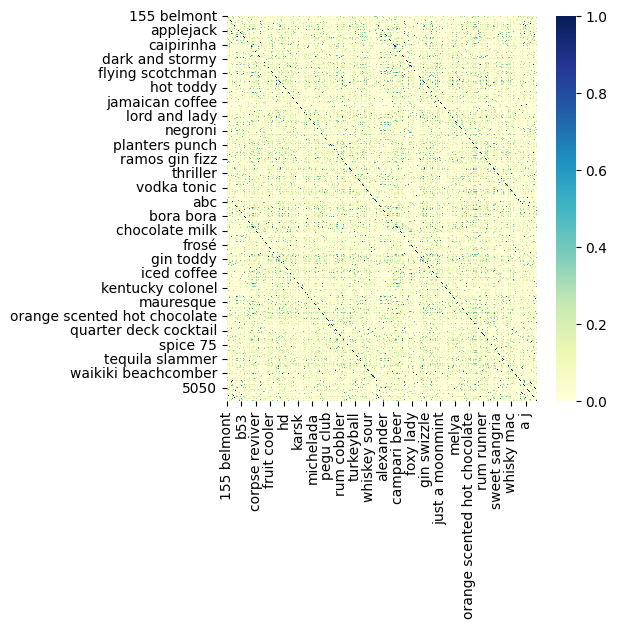

In [64]:
create_heatmap(cosine_similarity(arr))

In [65]:
def similar_cocktail(initial_cocktail):
    similarity_table = pd.DataFrame(cosine_similarity(arr), columns=cocktail_df['drink'], index=cocktail_df['drink'])
    for column in similarity_table.columns:
        similarity_table[column] = np.where(similarity_table[column] >= 1, 0, similarity_table[column])
    similar_cocktail= similarity_table.idxmax()

    return similar_cocktail[initial_cocktail]

In [73]:
similar_cocktail('a1')[0]

'talos coffee'

### Pickling the model file for deployment

In [67]:
import pickle

In [68]:
pickle.dump(X, open('tfidf.pkl','wb'))

In [69]:
pickle.dump(similar_cocktail, open('similar_cocktail.pkl','wb'))

In [70]:
pickled_model = pickle.load(open('tfidf.pkl','rb'))

In [71]:
pickled_rec = pickle.load(open('similar_cocktail.pkl','rb'))

In [74]:
pickled_rec('a1')[0]

'talos coffee'